# Auswertung bestes kNN

#### Importe

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from pathlib import Path
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
import timeit
import joblib

#### Plot Stylesheet

In [2]:
plt.style.use(['seaborn-v0_8-paper', Path.cwd().parent / 'plotstyle' / 'paper.mplstyle'])
cm = 1/2.54

#### Laden des kNNs

In [3]:
knn_model = joblib.load(Path.cwd().parent / 'data/models/knn_008_003.sav')
#knn_model.eval()

#### Einblick ins Netzwerk

In [4]:
#print(list(net.named_parameters()))

#### Laden der Normalisierungsdaten

In [4]:
# Standardisierungsdaten
norm_data_file = Path.cwd().parent / 'data' / 'models' / 'params_008_003.npz'
norm_data = np.load(norm_data_file)

mean_in = (norm_data['mean_in'])
mean_out = (norm_data['mean_out'])
std_in = (norm_data['std_in'])
std_out = (norm_data['std_out'])

### Verläufe mit konstant gehaltenen Parametern

#### Laden und Preprocessing der GGW-Daten

In [5]:
# Daten Extrapolation
eq_data_file_T = Path.cwd().parent / 'data' / 'eq_dataset_T_var.npz' #Import der GGW Daten
data_T = np.load(eq_data_file_T)

# Bei Speicherung wurden Daten als T, p, x_0 und x gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Output x[NH3]
T = np.array(data_T['T'])
p = np.array(data_T['p'])
x_0 = np.array(data_T['x_0'])
x = np.array(data_T['x'])

X = np.stack((T, p , np.full_like(T, x_0[0]),np.full_like(T, x_0[1]),np.full_like(T, x_0[2])),axis=1)
y = x # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen

#print(mean_out)

X_norm = (X - mean_in) / std_in
y_norm = (y - mean_out[1]) / std_out[1]
# print(X_norm)
#print(p)

#### Vorhersage der GGW-Daten

In [6]:
pred_norm = knn_model.predict(X_norm)
#print(pred_norm)

#### Auswertung des Verlaufs mit konstantem Druck und konstanten x_0 - Parity Plot

Training Dataset: R^2(NH3) = 0.9853260652198657
Max Error Training: |x_NH3 - x_NH3,pred| = 0.025480127492367943


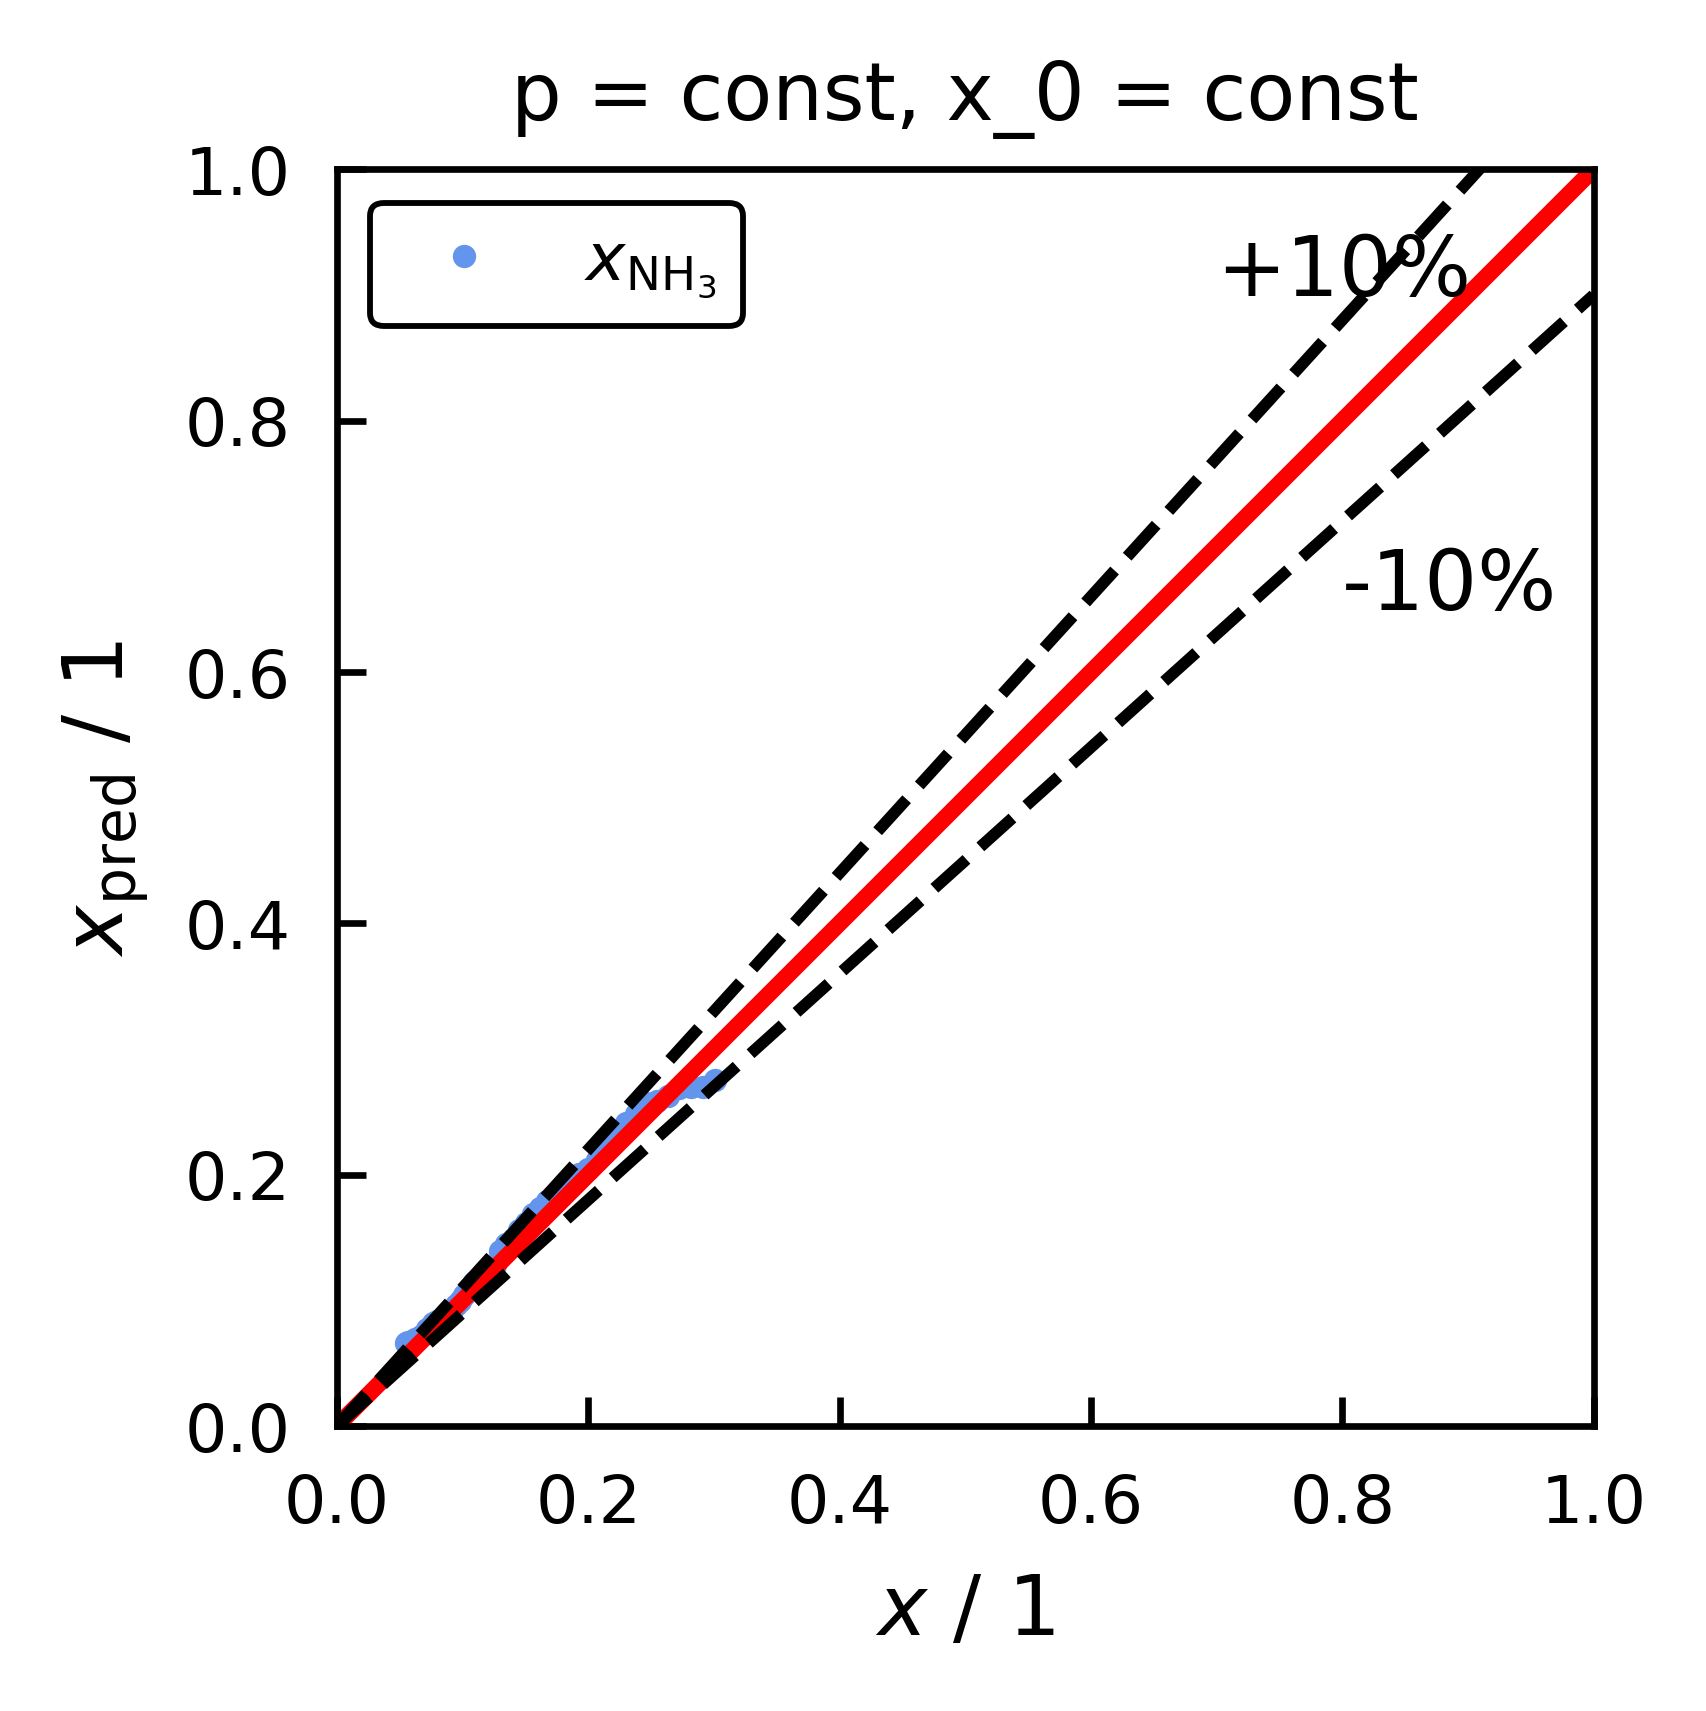

In [7]:
x_NH3_real_norm = y_norm
x_NH3_pred_norm = pred_norm[:,1]

x_NH3_real = x_NH3_real_norm * std_out[1] + mean_out[1]
x_NH3_pred = x_NH3_pred_norm * std_out[1] + mean_out[1]

print('Training Dataset: R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Max Error Training: |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))

# Set the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1, figsize =(7.5*cm,7.5*cm))

# # Reset the limits
# ax[0] = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

ax.plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax.plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax.transAxes)
ax.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax.text(0.7, 0.9, '+10%')
ax.text(0.8, 0.65, '-10%')
ax.set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
ax.set_title('p = const, x_0 = const')
ax.legend()
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Auswertung Verlauf x_NH3 über T, p =const, x_0 = const

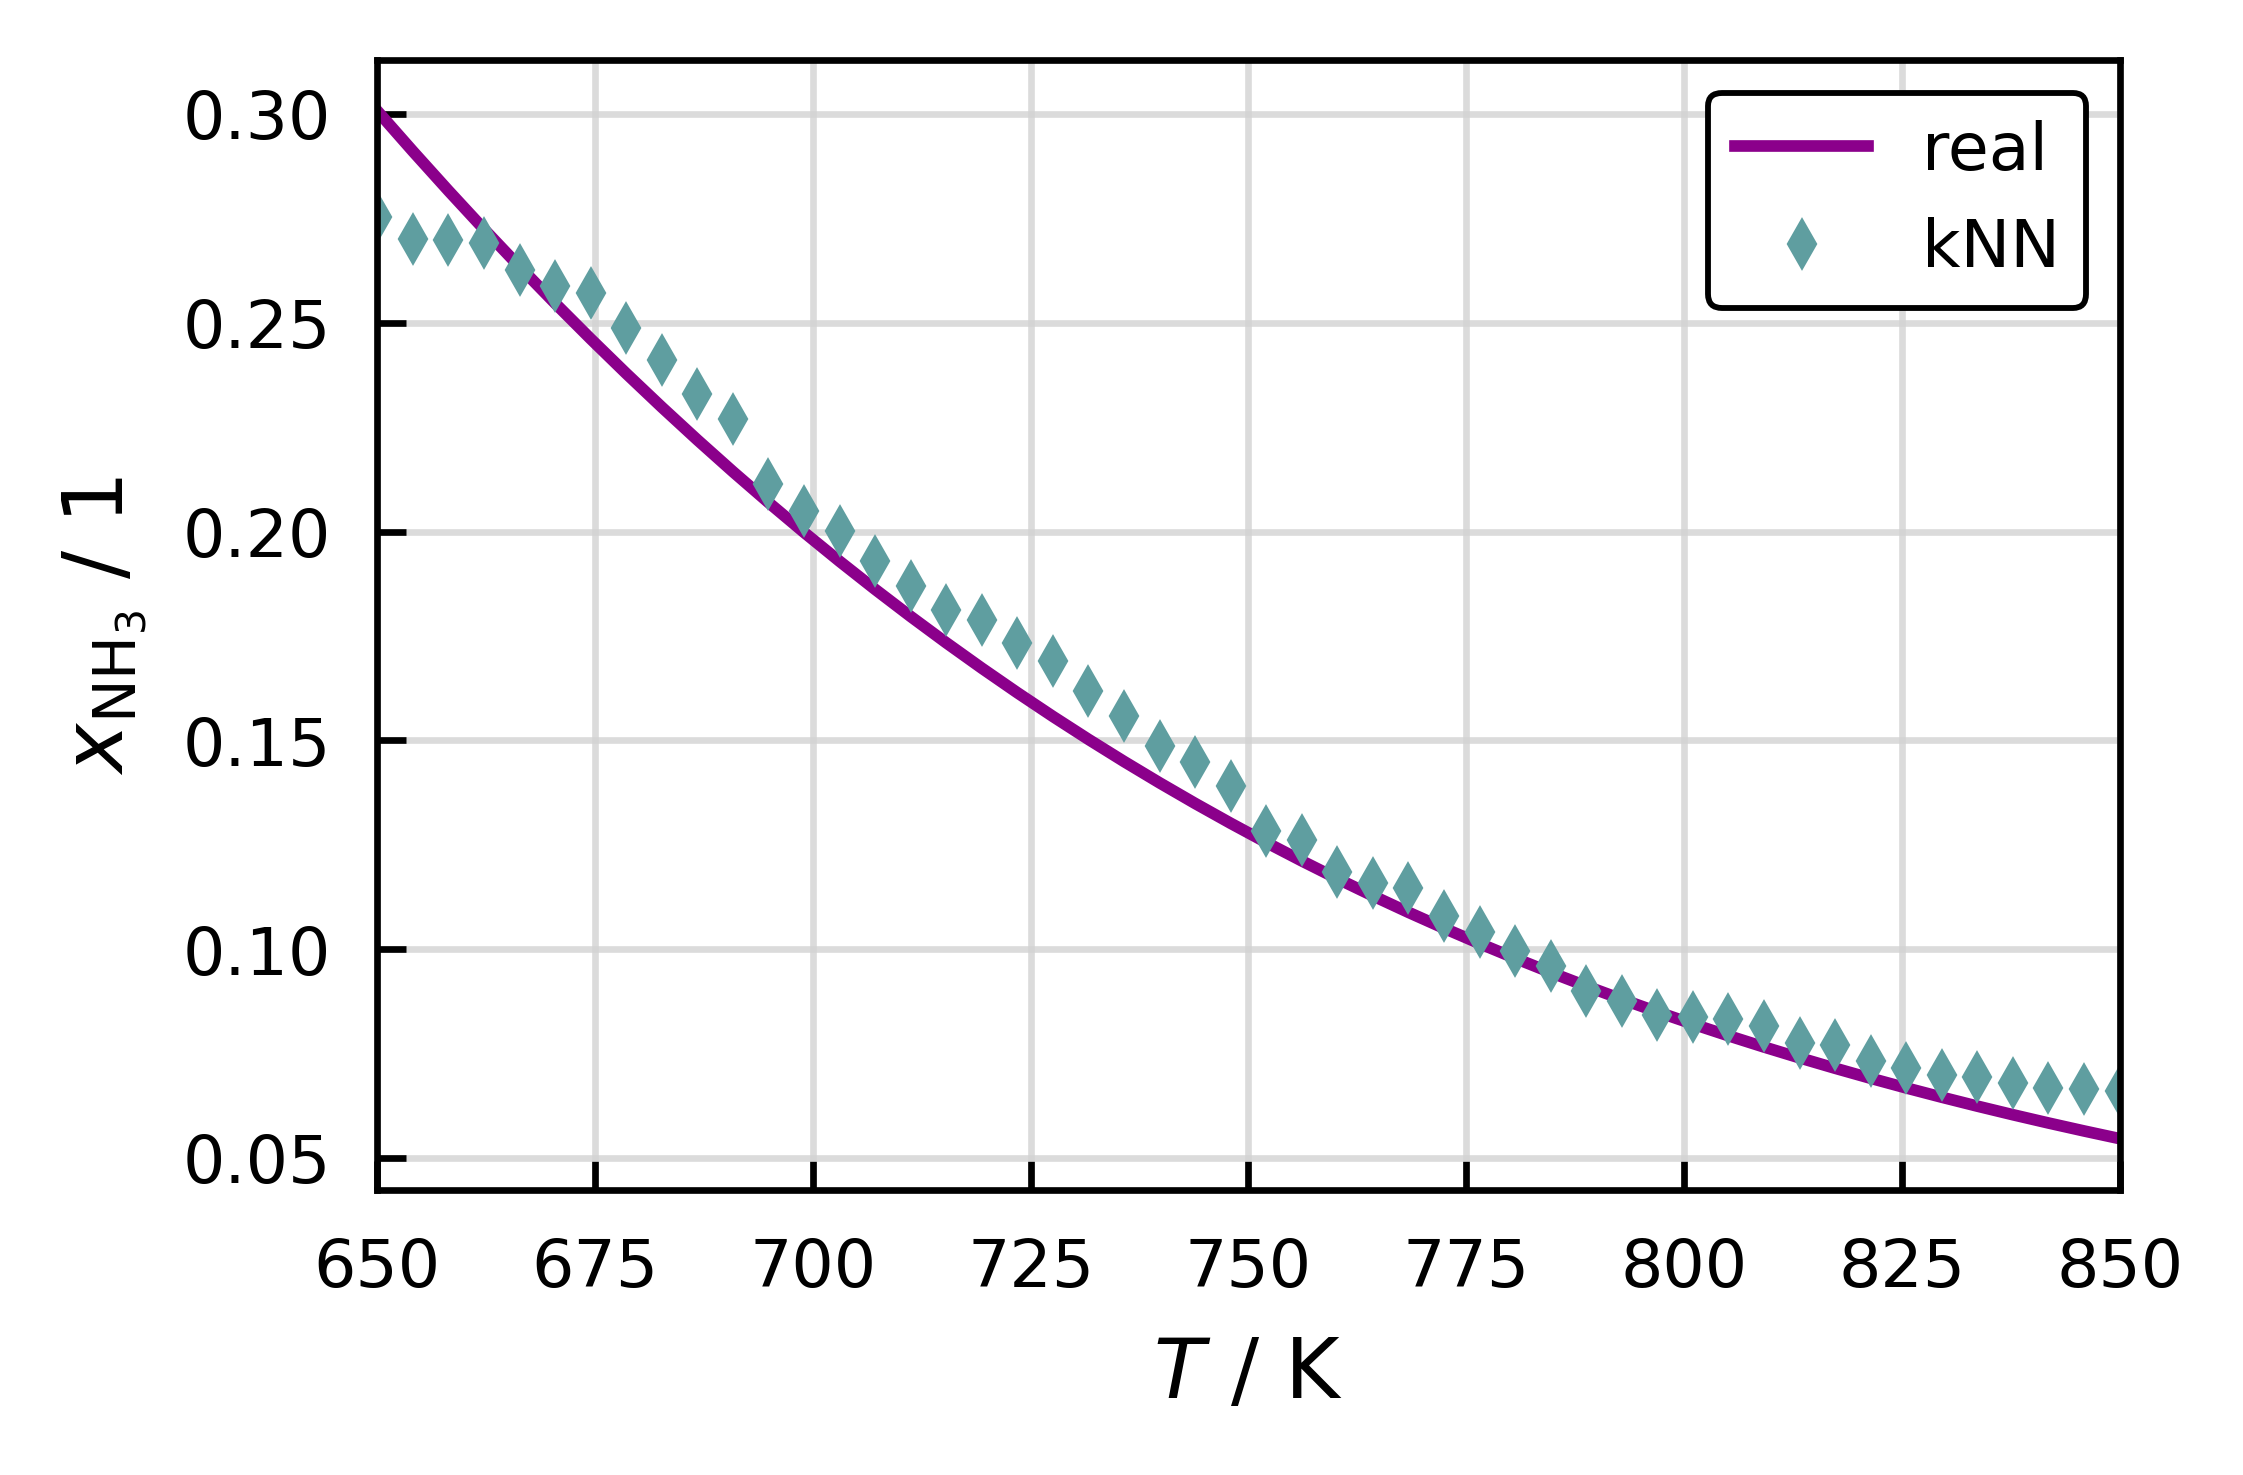

In [8]:
fig,ax = plt.subplots(figsize=(9.75*cm, 6.5*cm))

ax.plot(X[:,0], x_NH3_real, '-', label = 'real')
ax.plot(X[:,0], x_NH3_pred, 'd', markeredgewidth = 0.7, markersize = 3.5,label = 'kNN')
ax.set(xlabel = '$T$ / K', ylabel = '$x\mathregular{_{NH_3}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
#ax.set_title('p = const, x_0 = const')
ax.set(xlim=(650,850))
ax.legend()
ax.grid()
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

In [10]:
#fig.savefig(Path.cwd().parent / 'plots/knn/TKA_SRA_PK_001_verlauf.png', bbox_inches = 'tight')

In [9]:
#np.savez(Path.cwd().parent / 'data/models/verlauf/v_knn_008_003', T = X[:,0], x_NH3_pred = x_NH3_pred, x_NH3_real = x_NH3_real)

### Extrapolation

#### Laden und Preprocessing der GGW-Daten

In [9]:
# Daten Extrapolation
eq_data_file_extra = Path.cwd().parent / 'data' / 'eq_dataset_x_extra.npz' #Import der GGW Daten
extra_data = np.load(eq_data_file_extra)

# Bei Speicherung wurden Daten als T, p, x_0 und x gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Output x[H2, NH3]
T = (extra_data['T'])
p = (extra_data['p'])
x_0 = (extra_data['x_0'])
x = (extra_data['x'])

X = np.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),axis=1)
y = np.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen

X_norm = (X - mean_in) / std_in
y_norm = (y - mean_out) / std_out

# print(y)
# 
#print(y_norm.size())

#### Vorhersage der GGW-Daten

In [10]:
#Vorhersage
pred_norm = knn_model.predict(X_norm)
#print(pred_norm)

#### Auswertung der Extrapolation - Parity Plot

Training Dataset: R^2(H2) = 0.7210873166111917 , R^2(NH3) = 0.2576515986387613
Max Error Training: |x_H2 - x_H2,pred| = 0.32393608984841504 , |x_NH3 - x_NH3,pred| = 0.3930054009928228


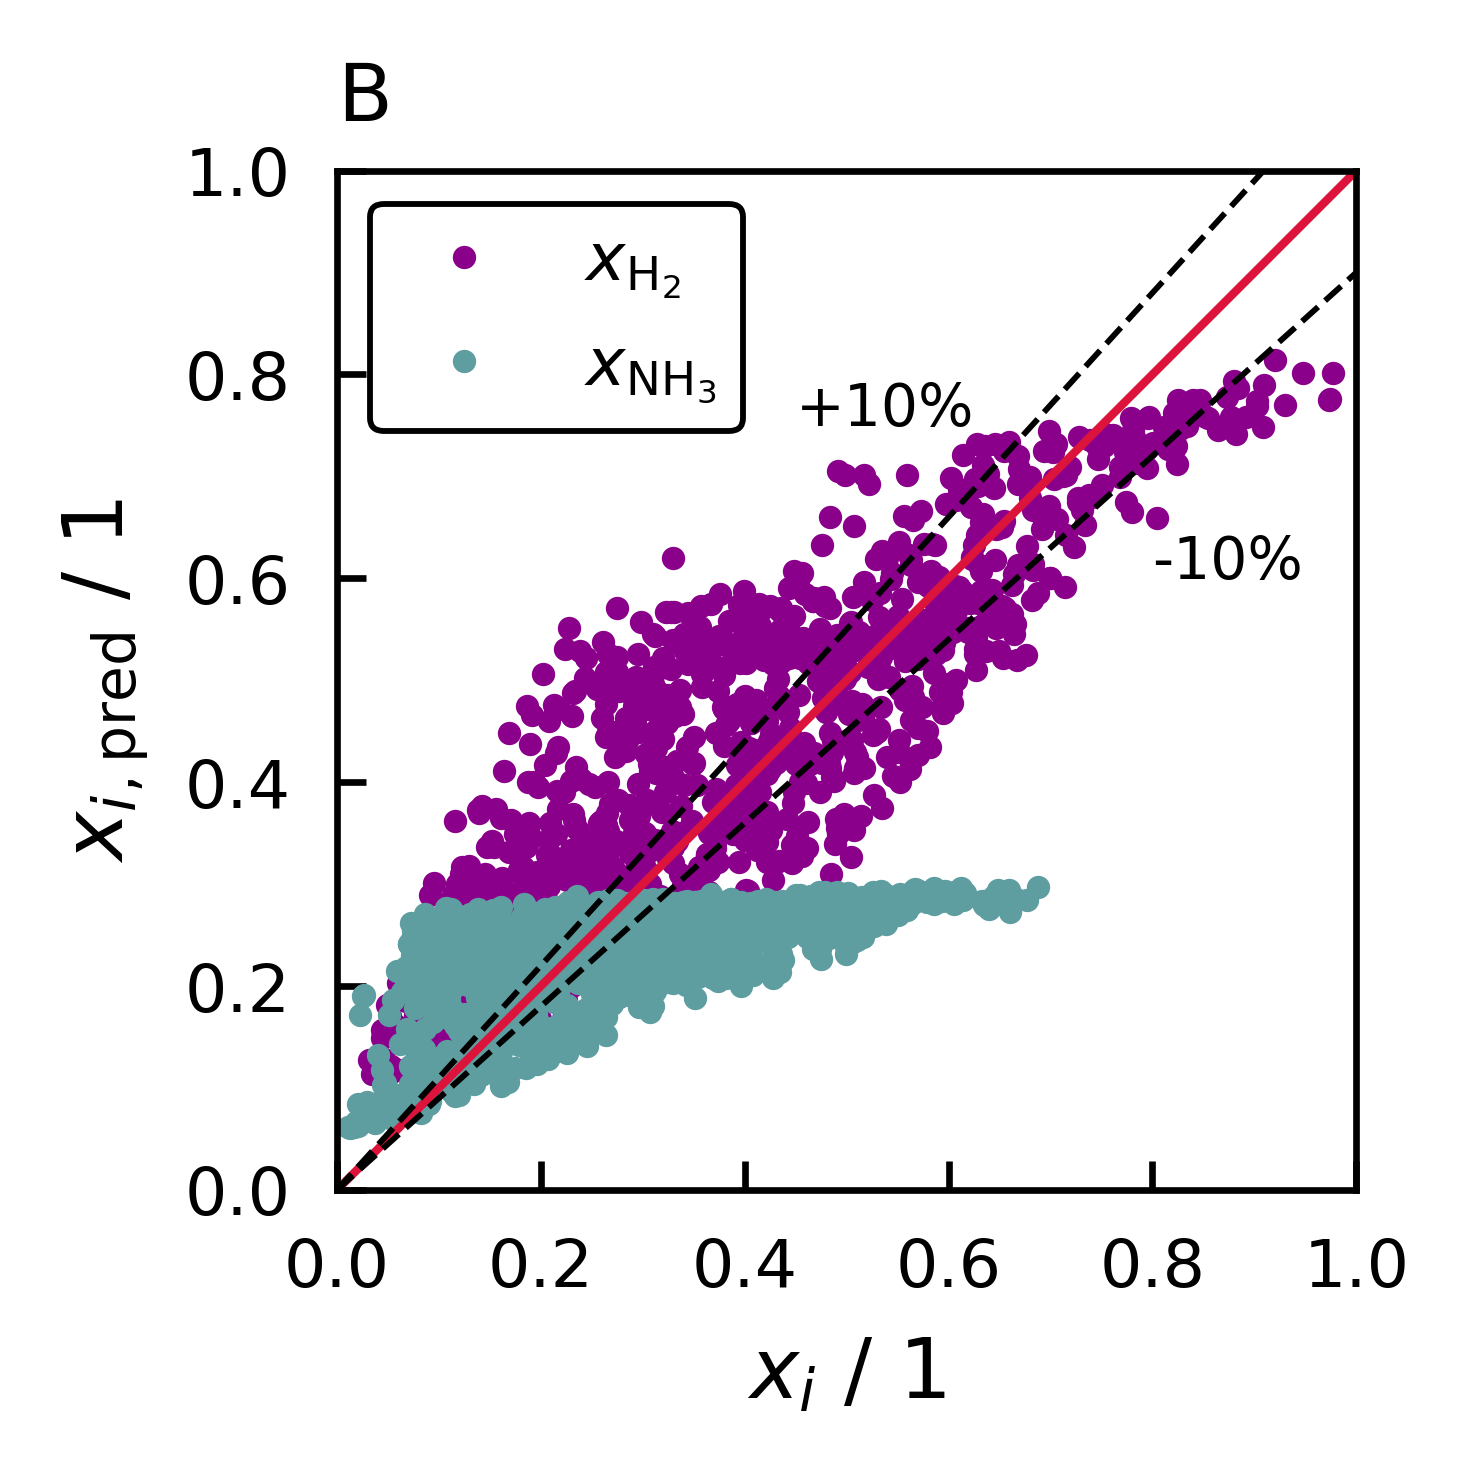

In [11]:
x_H2_real_norm = y_norm[:,0]
x_NH3_real_norm = y_norm[:,1]
x_H2_pred_norm = pred_norm[:,0] 
x_NH3_pred_norm = pred_norm[:,1]

x_H2_real = x_H2_real_norm * std_out[0] + mean_out[0]
x_H2_pred = x_H2_pred_norm * std_out[0] + mean_out[0]
x_NH3_real = x_NH3_real_norm * std_out[1] + mean_out[1]
x_NH3_pred = x_NH3_pred_norm * std_out[1] + mean_out[1]

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1, figsize =(6.5*cm,6.5*cm))

# # Reset the limits
# ax[0] = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

ax.plot(x_H2_real, x_H2_pred, '.', label = '$x\mathregular{_{H_2}}$')
ax.plot(x_NH3_real, x_NH3_pred, '.', label = '$x\mathregular{_{NH_3}}$')
ax.plot([0, 1], [0, 1], "-", color = 'crimson',lw=1 ,transform=ax.transAxes)
ax.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=0.7) # Error line
ax.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=0.7) # Error line
ax.text(0.45, 0.75, '+10%', fontsize=7)
ax.text(0.8, 0.6, '-10%', fontsize=7)
ax.set(xlabel = '$x_i$ / 1', ylabel = '$x_i\mathregular{_{,pred}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
ax.set_title('B', loc = 'left')
ax.legend()
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

In [15]:
#fig.savefig(Path.cwd().parent / 'plots/knn/TKA_SRA_PK_002_parity_extra_1.png', bbox_inches = 'tight')

### Wie weit extrapolierbar?

#### Laden und Preprocessing der Daten; p = const; x_0 = const

In [12]:
# Daten Extrapolation
eq_data_file_T_var_extra_haber = Path.cwd().parent / 'data' / 'eq_dataset_T_var_extra_haber.npz' #Import der GGW Daten
data_T_extra_haber = np.load(eq_data_file_T_var_extra_haber)

# Bei Speicherung wurden Daten als T, p, x_0 und x gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Output x[NH3]
T = (data_T_extra_haber['T'])
p = (data_T_extra_haber['p'])
x_0 = (data_T_extra_haber['x_0'])
x = (data_T_extra_haber['x'])

X_1 = np.stack((T, np.full_like(T, p[0]) , np.full_like(T, x_0[0]),np.full_like(T, x_0[1]),np.full_like(T, x_0[2])),1)
y_1 = x[:,0] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_2 = np.stack((T, np.full_like(T, p[1]) , np.full_like(T, x_0[0]),np.full_like(T, x_0[1]),np.full_like(T, x_0[2])),1)
y_2 = x[:,1] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_3 = np.stack((T, np.full_like(T, p[2]) , np.full_like(T, x_0[0]),np.full_like(T, x_0[1]),np.full_like(T, x_0[2])),1)
y_3 = x[:,2] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_4 = np.stack((T, np.full_like(T, p[3]) , np.full_like(T, x_0[0]),np.full_like(T, x_0[1]),np.full_like(T, x_0[2])),1)
y_4 = x[:,3] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_5 = np.stack((T, np.full_like(T, p[4]) , np.full_like(T, x_0[0]),np.full_like(T, x_0[1]),np.full_like(T, x_0[2])),1)
y_5 = x[:,4] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
# print(X)

X_1_norm = (X_1 - mean_in) / std_in
y_1_norm = (y_1 - mean_out[1]) / std_out[1]
X_2_norm = (X_2 - mean_in) / std_in
y_2_norm = (y_2 - mean_out[1]) / std_out[1]
X_3_norm = (X_3 - mean_in) / std_in
y_3_norm = (y_3 - mean_out[1]) / std_out[1]
X_4_norm = (X_4 - mean_in) / std_in
y_4_norm = (y_4 - mean_out[1]) / std_out[1]
X_5_norm = (X_5 - mean_in) / std_in
y_5_norm = (y_5 - mean_out[1]) / std_out[1]
# print(X_norm)
# print(mean_in)

#### Vorhersage der GGW Daten

In [13]:
pred_1 = knn_model.predict(X_1_norm)
pred_2 = knn_model.predict(X_2_norm)
pred_3 = knn_model.predict(X_3_norm)
pred_4 = knn_model.predict(X_4_norm)
pred_5 = knn_model.predict(X_5_norm)

#### Auswertung Verlauf x_NH3 über T, p =const, x_0 = const, Inter- und Extrapolation

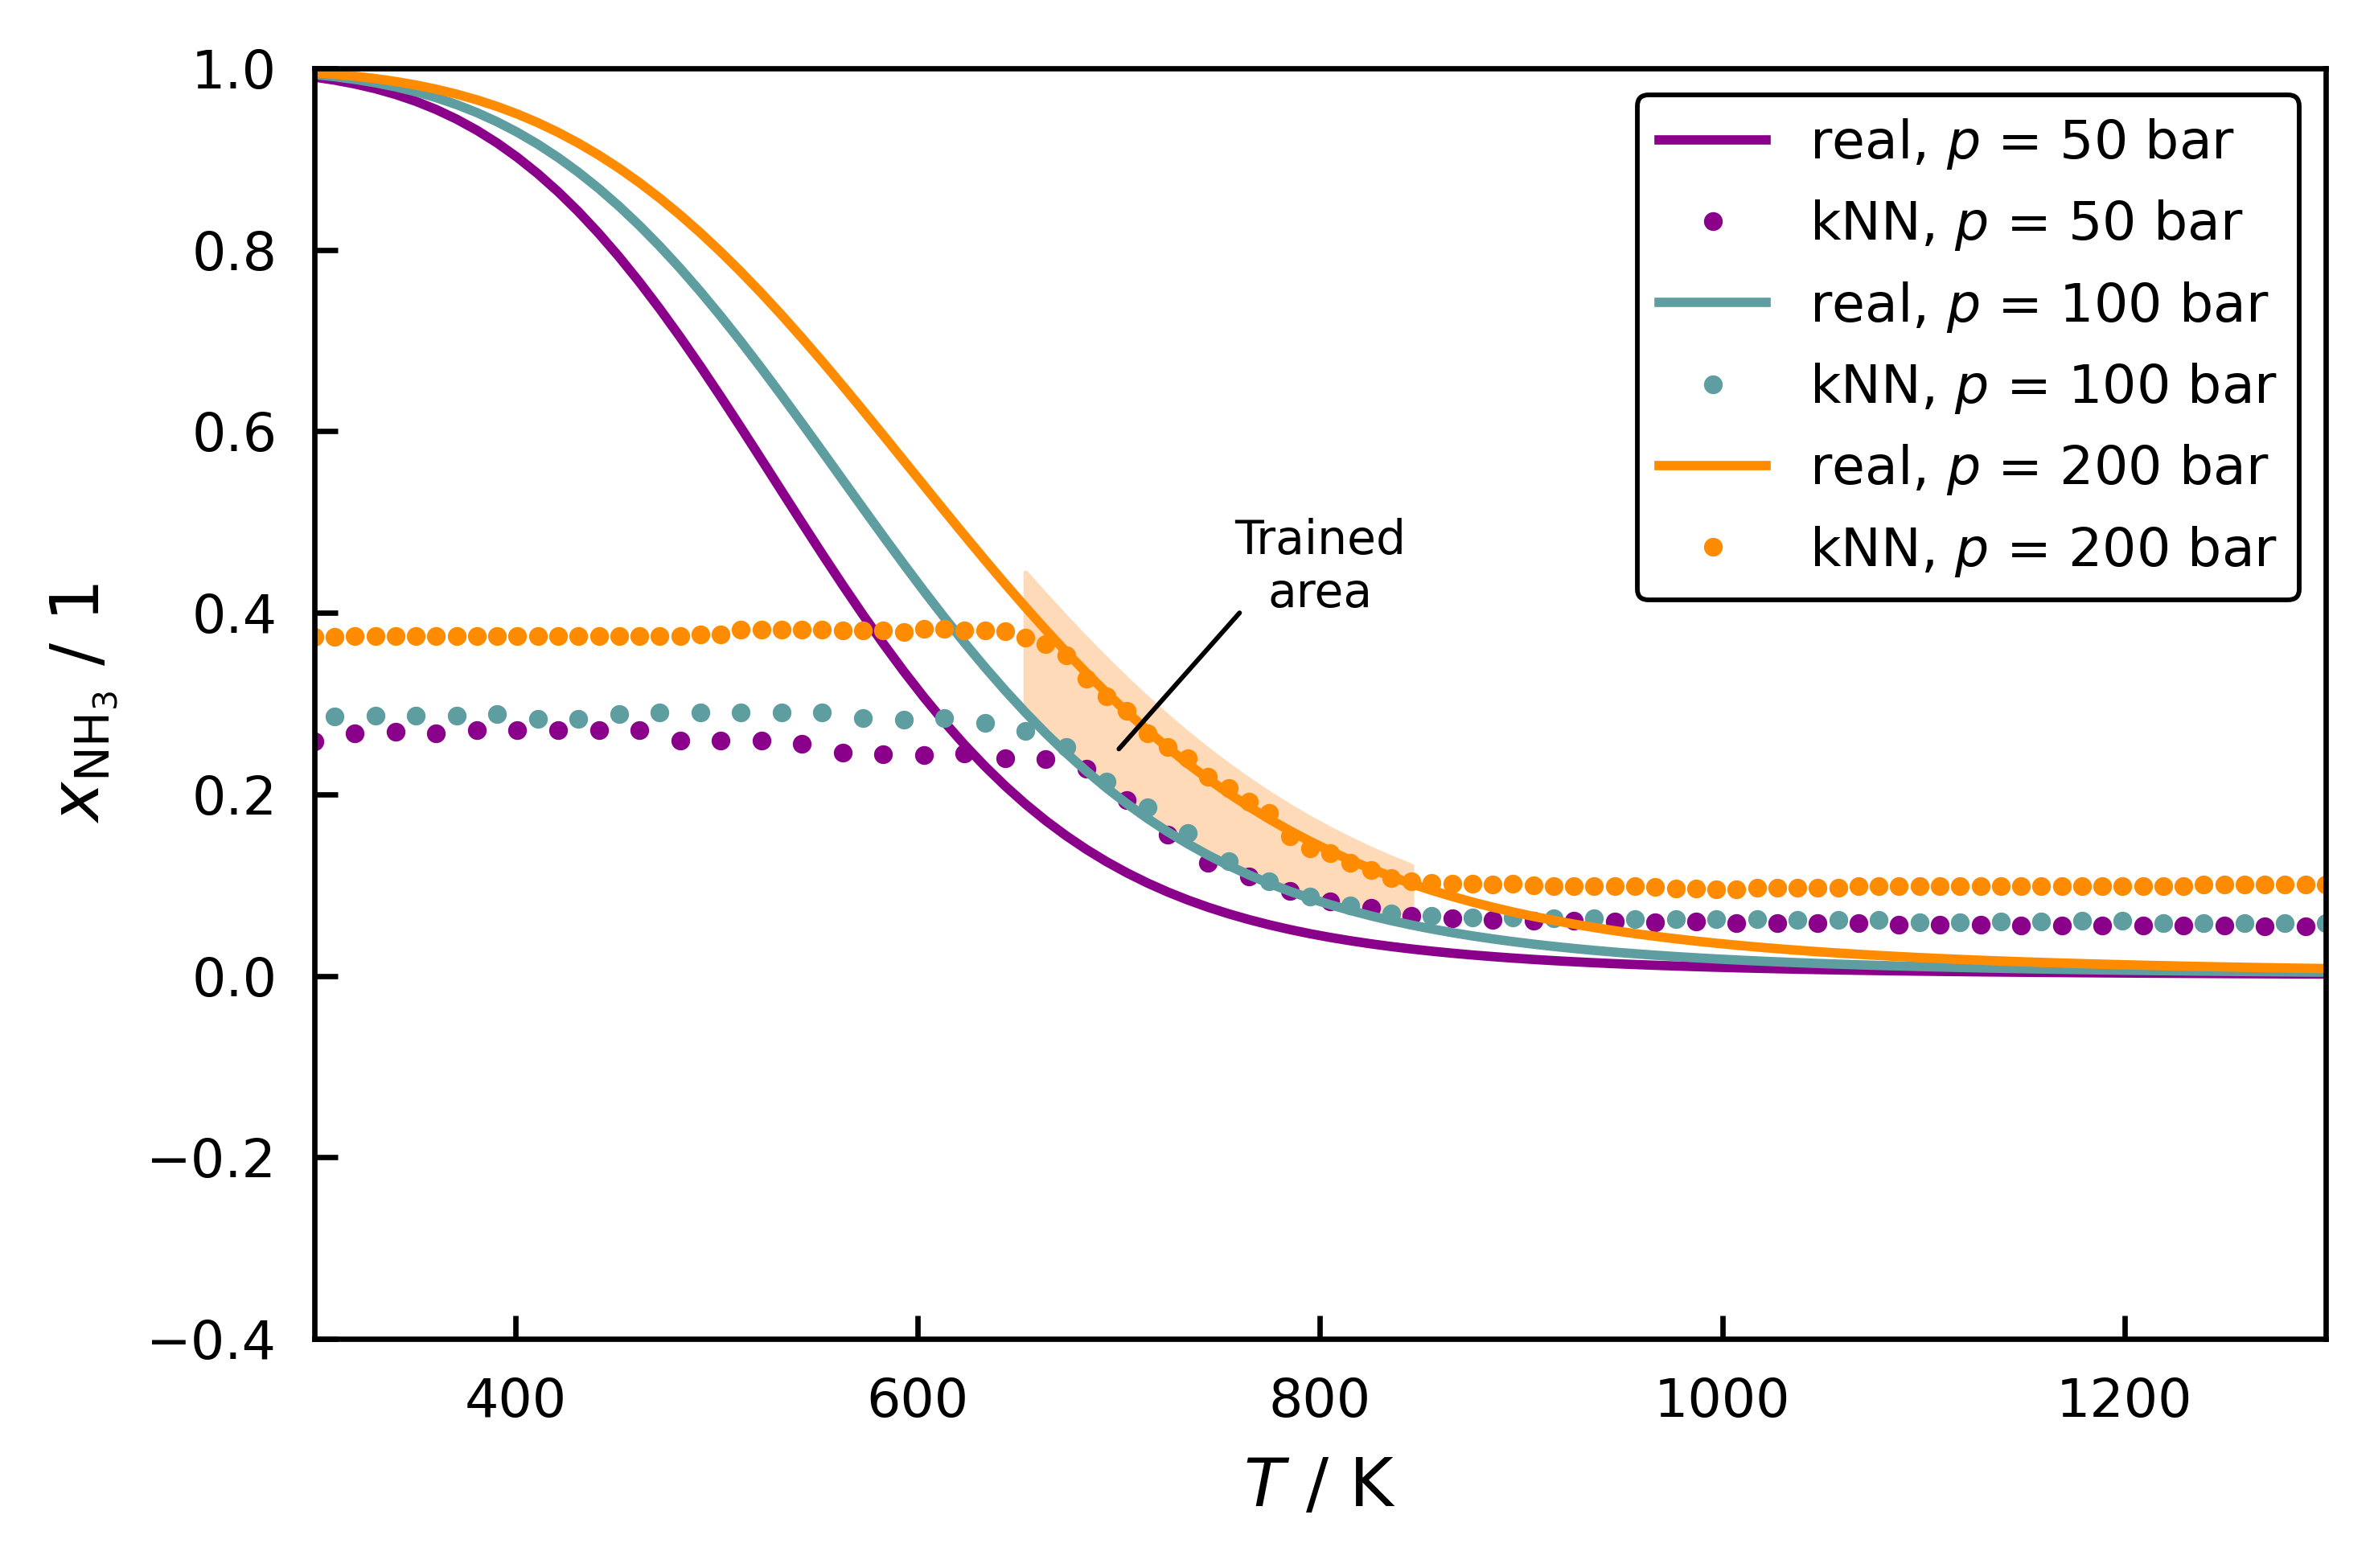

In [14]:
x_NH3_real_norm_1 = y_1_norm
x_NH3_pred_norm_1 = pred_1[:,1]
x_NH3_real_norm_2 = y_2_norm
x_NH3_pred_norm_2 = pred_2[:,1]
x_NH3_real_norm_3 = y_3_norm
x_NH3_pred_norm_3 = pred_3[:,1]
x_NH3_real_norm_4 = y_4_norm
x_NH3_pred_norm_4 = pred_4[:,1]
x_NH3_real_norm_5 = y_5_norm
x_NH3_pred_norm_5 = pred_5[:,1]

x_NH3_real_1 = x_NH3_real_norm_1 * std_out[1] + mean_out[1]
x_NH3_pred_1 = x_NH3_pred_norm_1 * std_out[1] + mean_out[1]
x_NH3_real_2 = x_NH3_real_norm_2 * std_out[1] + mean_out[1]
x_NH3_pred_2 = x_NH3_pred_norm_2 * std_out[1] + mean_out[1]
x_NH3_real_3 = x_NH3_real_norm_3 * std_out[1] + mean_out[1]
x_NH3_pred_3 = x_NH3_pred_norm_3 * std_out[1] + mean_out[1]
x_NH3_real_4 = x_NH3_real_norm_4 * std_out[1] + mean_out[1]
x_NH3_pred_4 = x_NH3_pred_norm_4 * std_out[1] + mean_out[1]
x_NH3_real_5 = x_NH3_real_norm_5 * std_out[1] + mean_out[1]
x_NH3_pred_5 = x_NH3_pred_norm_5 * std_out[1] + mean_out[1]

#print(x_NH3_pred_1)
fig,ax = plt.subplots()

ax.plot(X_1[:,0], x_NH3_real_1, '-', color ='darkmagenta', label = 'real, $p$ = 50 bar')
ax.plot(X_1[:,0][::2], x_NH3_pred_1[::2], '.', color ='darkmagenta', label = 'kNN, $p$ = 50 bar')
ax.plot(X_2[:,0], x_NH3_real_2, '-', color ='cadetblue', label = 'real, $p$ = 100 bar')
ax.plot(X_2[1:,0][::2], x_NH3_pred_2[1:][::2], '.', color ='cadetblue', label = 'kNN, $p$ = 100 bar')
ax.plot(X_3[:,0], x_NH3_real_3, '-', color ='darkorange', label = 'real, $p$ = 200 bar')
ax.plot(X_3[:,0], x_NH3_pred_3, '.', color ='darkorange', label = 'kNN, $p$ = 200 bar')
# ax.plot(X_4[:,0], x_NH3_real_4, '-', color ='crimson', label = 'real, p = 250 bar')
# ax.plot(X_4[:,0], x_NH3_pred_4, '.', color ='crimson', label = 'aNN, p = 250 bar')
# ax.plot(X_5[:,0], x_NH3_real_5, '-', color ='yellowgreen', label = 'real, p = 300 bar')
# ax.plot(X_5[:,0], x_NH3_pred_5, '.', color ='yellowgreen', label = 'aNN, p = 300 bar')

# ax.axvline(x=650, color='black', linestyle='dashed')
# ax.axvline(x=850, color='black', linestyle='dashed')

#fill in training arreas
X_help = X_2
index_650 = np.where(X_help[:,0] >= 650)[0][0]
index_850 = np.where(X_help[:,0] >= 850)[0][0]

# print(index_500)
# print(X_2[index_500:index_650,0])
fill = ax.fill_between(X_2[index_650:index_850, 0],x_NH3_real_2[index_650:index_850], x_NH3_real_4[index_650:index_850], color = 'peachpuff', alpha = 1, zorder=1)#, label = 'Haber-Bosch')#,alpha = 0.6)

#Beschriftung Fläche
(x0, y0), (x1, y1) = fill.get_paths()[0].get_extents().get_points()
ax.text(800, (y0 + y1) / 2 + 0.2, "Trained\narea", ha='center', va='center', fontsize=7, color='black', zorder=100)
con = ConnectionPatch(xyA=(700, 0.25), coordsA=ax.transData,
                      xyB=(760,0.4), coordsB=ax.transData, lw = 0.7, zorder=100)
ax.add_artist(con)
ax.set(xlabel = '$T$ / K', ylabel = '$x\mathregular{_{NH_3}}$ / 1')
ax.set(xlim=(300,1300),ylim=(-0.4,1))
ax.tick_params(direction = 'in') #, length = 20, width = 3)
#ax.set_title('p = const, x_0 = const')
ax.legend()
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

In [18]:
#fig.savefig(Path.cwd().parent / 'plots/knn/TKA_SRA_PK_003_verlauf_extra_1.png', bbox_inches = 'tight')

#### Parity Plot

653.5353535353536
855.5555555555555


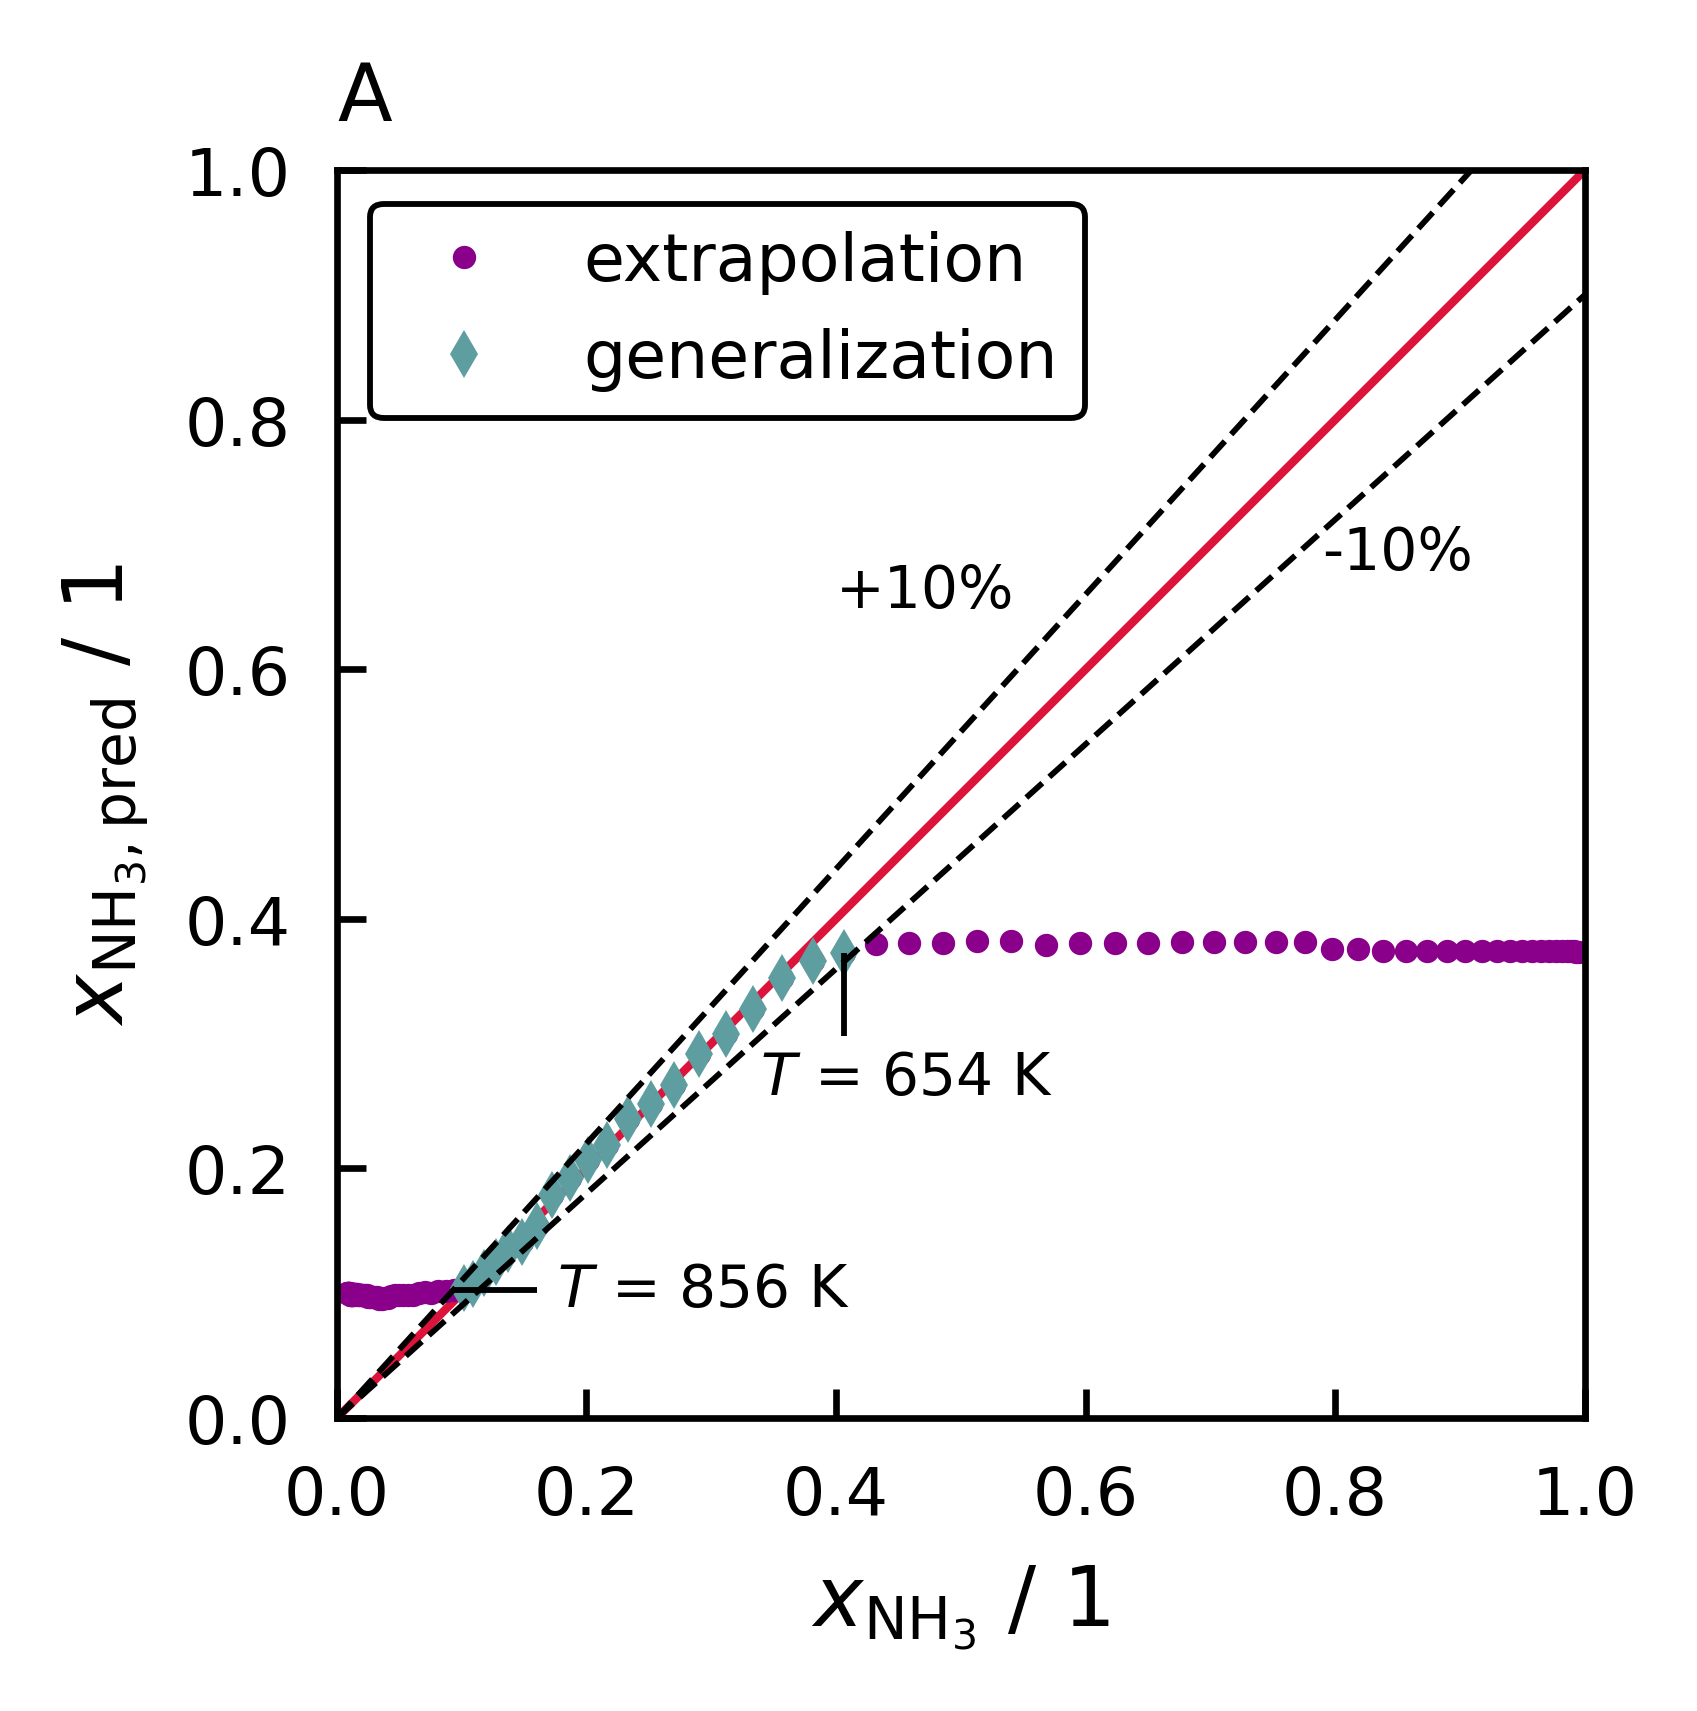

In [16]:
# Set the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1, figsize =(7.5*cm,7.5*cm))

# # Reset the limits
# ax[0] = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

ax.plot([0, 1], [0, 1], "-", color='crimson', lw=1 ,transform=ax.transAxes)
ax.plot(x_NH3_real_3, x_NH3_pred_3, '.', label = 'extrapolation')
ax.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=0.7, zorder=100) # Error line
ax.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=0.7, zorder=100) # Error line
ax.text(0.4, 0.65, '+10%', fontsize=7)
ax.text(0.79, 0.68, '-10%', fontsize=7)
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Einfärben der Datenpunkte im Trainingsbereich
ax.plot(x_NH3_real_3[index_650:index_850], x_NH3_pred_3[index_650:index_850], 'd', markersize = 4, label='generalization')

# X_help = X_2.numpy()
index_down = np.where(x_NH3_pred_3 >= x_NH3_real_3 * 0.9)[0][0]
index_up = np.where(x_NH3_pred_3 <= x_NH3_real_3 * 1.1)[0][-1]
print(X_2[index_down,0])
print(X_2[index_up,0])
ax.plot(x_NH3_real_3[index_down], x_NH3_pred_3[index_down], marker = 3, markeredgewidth = 0.7, markersize=10,color='black')
ax.plot(x_NH3_real_3[index_up], x_NH3_pred_3[index_up], marker=1, markeredgewidth = 0.7, markersize=10,color='black')

#Text
ax.text(x_NH3_real_3[index_down]+0.05, x_NH3_pred_3[index_down] -0.1, ("$T$ = 654 K"), ha='center', va='center', fontsize=7, color='black', zorder=100)
ax.text(x_NH3_real_3[index_up]+0.2, x_NH3_pred_3[index_up], ("$T$ = 856 K"), ha='center', va='center', fontsize=7, color='black', zorder=100)

ax.set(xlabel = '$x\mathregular{_{NH_3}}$ / 1', ylabel = '$x\mathregular{_{NH_{3},pred}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
ax.set_title('A', loc='left')
ax.legend(loc='upper left')
#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

In [17]:
#fig.savefig(Path.cwd().parent / 'plots/knn/TKA_SRA_PK_004_parity_extra_2.png', bbox_inches = 'tight')

#### Laden und Preprocessing der Daten; T = const, x_0 = const

In [18]:
# Daten Extrapolation
eq_data_file_p_var_extra_haber = Path.cwd().parent / 'data' / 'eq_dataset_p_var_extra_haber.npz' #Import der GGW Daten
data_p_extra_haber = np.load(eq_data_file_p_var_extra_haber)

# Bei Speicherung wurden Daten als T, p, x_0 und x gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Output x[NH3]
T = (data_p_extra_haber['T'])
p = (data_p_extra_haber['p'])
x_0 = (data_p_extra_haber['x_0'])
x = (data_p_extra_haber['x'])

X_1 = np.stack((np.full_like(p, T[0]), p, np.full_like(p, x_0[0]),np.full_like(p, x_0[1]),np.full_like(p, x_0[2])),1)
y_1 = x[:,0] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_2 = np.stack((np.full_like(p, T[1]), p, np.full_like(p, x_0[0]),np.full_like(p, x_0[1]),np.full_like(p, x_0[2])),1)
y_2 = x[:,1] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_3 = np.stack((np.full_like(p, T[2]), p, np.full_like(p, x_0[0]),np.full_like(p, x_0[1]),np.full_like(p, x_0[2])),1)
y_3 = x[:,2] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_4 = np.stack((np.full_like(p, T[3]), p, np.full_like(p, x_0[0]),np.full_like(p, x_0[1]),np.full_like(p, x_0[2])),1)
y_4 = x[:,3] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
# print(X)

X_1_norm = (X_1 - mean_in) / std_in
y_1_norm = (y_1 - mean_out[1]) / std_out[1]
X_2_norm = (X_2 - mean_in) / std_in
y_2_norm = (y_2 - mean_out[1]) / std_out[1]
X_3_norm = (X_3 - mean_in) / std_in
y_3_norm = (y_3 - mean_out[1]) / std_out[1]
X_4_norm = (X_4 - mean_in) / std_in
y_4_norm = (y_4 - mean_out[1]) / std_out[1]
# print(X_norm)
# print(mean_in)

#### Vorhersage der GGW Daten

In [19]:
pred_1 = knn_model.predict(X_1_norm)
pred_2 = knn_model.predict(X_2_norm)
pred_3 = knn_model.predict(X_3_norm)
pred_4 = knn_model.predict(X_4_norm)

#### Auswertung Verlauf x_NH3 über p, T =const, x_0 = const, Inter- und Extrapolation

In [20]:
x_NH3_real_norm_1 = y_1_norm
x_NH3_pred_norm_1 = pred_1[:,1]
x_NH3_real_norm_2 = y_2_norm
x_NH3_pred_norm_2 = pred_2[:,1]
x_NH3_real_norm_3 = y_3_norm
x_NH3_pred_norm_3 = pred_3[:,1]
x_NH3_real_norm_4 = y_4_norm
x_NH3_pred_norm_4 = pred_4[:,1]

x_NH3_real_1 = x_NH3_real_norm_1 * std_out[1] + mean_out[1]
x_NH3_pred_1 = x_NH3_pred_norm_1 * std_out[1] + mean_out[1]
x_NH3_real_2 = x_NH3_real_norm_2 * std_out[1] + mean_out[1]
x_NH3_pred_2 = x_NH3_pred_norm_2 * std_out[1] + mean_out[1]
x_NH3_real_3 = x_NH3_real_norm_3 * std_out[1] + mean_out[1]
x_NH3_pred_3 = x_NH3_pred_norm_3 * std_out[1] + mean_out[1]
x_NH3_real_4 = x_NH3_real_norm_4 * std_out[1] + mean_out[1]
x_NH3_pred_4 = x_NH3_pred_norm_4 * std_out[1] + mean_out[1]

fig,ax = plt.subplots()

ax.plot(X_1[:,1], x_NH3_real_1, '-', color ='darkmagenta', label = 'real, $T$ = 600 K')
ax.plot(X_1[:,1], x_NH3_pred_1, '.', color ='darkmagenta', label = 'kNN, $T$ = 600 K')
ax.plot(X_2[:,1], x_NH3_real_2, '-', color ='cadetblue', label = 'real, $T$ = 650 K')
ax.plot(X_2[:,1], x_NH3_pred_2, '.', color ='cadetblue', label = 'kNN, $T$ = 650 K')
ax.plot(X_3[:,1], x_NH3_real_3, '-', color ='darkorange', label = 'real, $T$ = 800 K')
ax.plot(X_3[:,1], x_NH3_pred_3, '.', color ='darkorange', label = 'kNN, $T$ = 800 K')
# ax.plot(X_4[:,1], x_NH3_real_4, '-', color ='crimson', label = 'real, $T$ = 850 K')
# ax.plot(X_4[:,1], x_NH3_pred_4, '.', color ='crimson', label = 'aNN, $T$ = 850 K')

# ax.axvline(x=100, color='black', linestyle='dashed')
# ax.axvline(x=250, color='black', linestyle='dashed')

#fill in training arreas
X_help = X_2
index_100 = np.where(X_help[:,1] >= 100)[0][0]
index_250 = np.where(X_help[:,1] >= 250)[0][0]

# print(index_500)
# print(X_2[index_500:index_650,0])
ax.fill_between(X_2[index_100:index_250, 1],x_NH3_real_2[index_100:index_250], x_NH3_real_4[index_100:index_250], color = 'peachpuff', alpha = 1, zorder=1)#, label = 'Haber-Bosch')#,alpha = 0.6)

#Beschriftung Fläche
ax.text(172,  0.23, "Trained\narea", ha='center', va='center', fontsize=7, color='black', zorder=100)
#con = ConnectionPatch(xyA=(200, 0.25), coordsA=ax.transData,
#                      xyB=(200,0.4), coordsB=ax.transData, lw = 0.7, zorder=100)
#ax.add_artist(con)

ax.set(xlim=(0,450),ylim=(0,0.8))
ax.set(xlabel = '$p$ / bar', ylabel = '$x\mathregular{_{NH_3}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
#ax.set_title('T = const, x_0 = const')
ax.legend(ncols=2)
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

In [24]:
#fig.savefig(Path.cwd().parent / 'plots/knn/TKA_SRA_PK_005_verlauf_extra_2.png', bbox_inches = 'tight')

#### Parity Plot

In [22]:
# Set the boundaries of X and Y values
bounds = (0,0.4)

fig,ax = plt.subplots(1, figsize =(7.5*cm,7.5*cm))

# # Reset the limits
# ax[0] = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

ax.plot([0, 1], [0, 1], "-", color='crimson', lw=1 ,transform=ax.transAxes)
ax.plot(x_NH3_real_3, x_NH3_pred_3, '.', label = 'extrapolation')
# ax.plot(x_NH3_real_2, x_NH3_pred_2, '.', color ='teal', label = '$T$ = 650 K')
# ax.plot(x_NH3_real_1, x_NH3_pred_1, '.', color ='orange', label = '$T$ = 600 K')
ax.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=0.7, zorder=100) # Error line
ax.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=0.7, zorder=100) # Error line
ax.text(0.18, 0.27, '+10%', fontsize=7)
ax.text(0.3, 0.25, '-10%', fontsize=7)

# Einfärben der Datenpunkte im Trainingsbereich
ax.plot(x_NH3_real_3[index_100:index_250], x_NH3_pred_3[index_100:index_250], 'd', markersize = 4, label='generalization')

# X_help = X_2.numpy()
index_up = np.where(x_NH3_pred_3 >= x_NH3_real_3 * 0.9)[0][-1]
index_down = np.where(x_NH3_pred_3 <= x_NH3_real_3 * 1.1)[0][0]
print(X_2[index_down,1])
print(X_2[index_up,1])
ax.plot(x_NH3_real_3[index_down], x_NH3_pred_3[index_down], marker = 2, markeredgewidth = 0.7, markersize=14,color='black')
ax.plot(x_NH3_real_3[index_up], x_NH3_pred_3[index_up], marker=3, markeredgewidth = 0.7, markersize=14,color='black')

#Text
ax.text(x_NH3_real_3[index_down]-0.02, x_NH3_pred_3[index_down] +0.05, ("$p$ = 96 bar"), ha='center', va='center', fontsize=7, color='black', zorder=100)
ax.text(x_NH3_real_3[index_up]+0.02, x_NH3_pred_3[index_up]-0.05, ("$p$ = 296 bar"), ha='center', va='center', fontsize=7, color='black', zorder=100)


plt.yticks(np.arange(0,0.5,0.1))
ax.set(xlabel = '$x\mathregular{_{NH_3}}$ / 1', ylabel = '$x\mathregular{_{NH_{3},pred}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
ax.set_title('B', loc='left')
ax.legend()
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

96.24242424242425
295.7979797979798


In [23]:
#fig.savefig(Path.cwd().parent / 'plots/knn/TKA_SRA_PK_006_parity_extra_3.png', bbox_inches = 'tight')

### Ermittlung der Laufzeit zur Vorhersage von Datenpunkten

#### Laden und Preprocessing der 10 000 und 100 000 Datenpunkte

In [31]:
# Datei zehntausend Datenpunkte laden
eq_data_file_x_ztsd = Path.cwd().parent / 'data' / 'eq_dataset_x_10000.npz' #Import der GGW Daten
data_ztsd = np.load(eq_data_file_x_ztsd)

# Bei Speicherung wurden Daten als T, p, x_0 und x gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Output x[H2, NH3]
T = (data_ztsd['T'])
p = (data_ztsd['p'])
x_0 = (data_ztsd['x_0'])
x = (data_ztsd['x'])

X_ztsd = np.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
X_norm_ztsd = (X_ztsd - mean_in) / std_in
# Datei hunderdtausend Datenpunkte laden
eq_data_file_x_zwtsd = Path.cwd().parent / 'data' / 'eq_dataset_x_20000.npz' #Import der GGW Daten
data_zwtsd = np.load(eq_data_file_x_zwtsd)

T = (data_zwtsd['T'])
p = (data_zwtsd['p'])
x_0 = (data_zwtsd['x_0'])

X_zwtsd = np.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
X_norm_zwtsd = (X_zwtsd - mean_in) / std_in

#### Bestimmung der Laufzeiten

In [36]:
X_1 = X_1_norm[:1] # 1 Datenpaar
X_100 = X_1_norm # 100 Datenpaare
X_500 = X_norm[:500] # 100 Datenpaare
X_1000 = X_norm # 1000 Datenpaare
X_5000 = X_norm_ztsd[:5000] # 5000 Datenpaare
X_10000 = X_norm_ztsd # 10 000 Datenpaare
X_20000 = X_norm_zwtsd # 20 000 Datenpaare
X_hdtsd = np.concatenate((X_norm_zwtsd, X_norm_zwtsd, X_norm_zwtsd, X_norm_zwtsd, X_norm_zwtsd), axis=0) # 100 000 Datenpaare

print(np.shape(X_1))
print(np.shape(X_100))
print(np.shape(X_500))
print(np.shape(X_1000))
print(np.shape(X_5000))
print(np.shape(X_10000))
print(np.shape(X_20000))
print(np.shape(X_hdtsd))

# pred_time_1 = timeit.timeit('knn_model.predict(X_1)', number = 10000, globals=globals()) / 10000
# pred_time_100 = timeit.timeit('knn_model.predict(X_100)', number = 10000, globals=globals()) / 10000
# pred_time_500 = timeit.timeit('knn_model.predict(X_500)', number = 10000, globals=globals()) / 10000
# pred_time_1000 = timeit.timeit('knn_model.predict(X_1000)', number = 10000, globals=globals()) / 10000
# pred_time_5000 = timeit.timeit('knn_model.predict(X_5000)', number = 1000, globals=globals()) / 1000
# pred_time_10000 = timeit.timeit('knn_model.predict(X_10000)', number = 1000, globals=globals()) / 1000
# pred_time_20000 = timeit.timeit('knn_model.predict(X_20000)', number = 1000, globals=globals()) / 1000
#pred_time_hdtsd = timeit.timeit('knn_model.predict(X_hdtsd)', number = 100, globals=globals()) / 100

print('1:', pred_time_1,'100:', pred_time_100, '500:', pred_time_500,'1000:', pred_time_1000, '5000:', pred_time_5000,'10 000:', pred_time_10000, '20 000:', pred_time_20000, '100 000:', pred_time_hdtsd)
#np.savez((Path.cwd().parent / 'data'/'knn_time.npz'), knn_time_1 = pred_time_1, knn_time_100 = pred_time_100, knn_time_500 = pred_time_500, knn_time_1000 = pred_time_1000, knn_time_5000 = pred_time_5000, knn_time_10000 = pred_time_10000, knn_time_20000 = pred_time_20000, knn_time_hdtsd = pred_time_hdtsd)

(1, 5)
(100, 5)
(500, 5)
(1000, 5)
(5000, 5)
(10000, 5)
(20000, 5)
(100000, 5)
1: 0.00046892457000212743 100: 0.0020165175899979656 500: 0.009078276760003064 1000: 0.017462368039996363 5000: 0.07398635590006597 10 000: 0.1431782286000671 20 000: 0.2941609003000194 100 000: 1.396241897
